# 手动实现前馈神经网络解多分类任务

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils import data
import numpy as np

## 1 下载 MNIST 手写体数据集

In [2]:
train_dataset = torchvision.datasets.MNIST(root="./", train=True, transform= transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.MNIST(root="./", train=False, transform= transforms.ToTensor(),download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=0)

## 2 模型参数定义及初始化

In [3]:
batch_size=128
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_hiddens)),dtype=torch.float)
b1 = torch.zeros(num_hiddens,dtype=torch.float)
W2 = torch.tensor(np.random.normal(0,0.01,(num_hiddens,num_outputs)),dtype=torch.float)
b2 = torch.zeros(num_outputs,dtype=torch.float)

In [4]:
params = [W1, b1, W2, b2]
W1.requires_grad_(requires_grad=True)
b1.requires_grad_(requires_grad=True)
W2.requires_grad_(requires_grad=True)
b2.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 3 定义激活函数

In [5]:
def relu(x):
    return torch.max(input=x,other=torch.tensor(0.0))

## 4 定义交叉熵损失函数

In [6]:
loss = torch.nn.CrossEntropyLoss()

## 5 定义随机梯度下降函数

In [7]:
def SGD(params,lr,batch_size):
    for param in params:
        param.data-=lr*param.grad/batch_size

## 6 定义模型

In [8]:
def net(X):
    X = X.view((-1,num_inputs))
    H = relu(torch.matmul(X,W1) + b1)
    return torch.matmul(H,W2) +b2

## 7 计算模型在测试数据集上的准确率

In [9]:
def evaluate_accuracy(data_inter,net):
    acc_num,n = 0.0,0
    for X,y in data_inter:
        acc_num+=(net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_num/n

## 8 模型训练，保存训练集和验证集的loss

In [11]:
x_l = []
train_loss = []
test_loss = []

In [12]:
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum,test_l_sum, train_acc_sum, m, n = 0.0, 0.0, 0.0, 0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params, lr, batch_size)
            else:
                optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            m += y.shape[0]
        x_l.append(epoch + 1)
        test_acc = evaluate_accuracy(test_iter, net)
        train_loss.append(train_l_sum / m)
        for X, y in test_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            test_l_sum += l.item()
            n += y.shape[0]
        test_loss.append(test_l_sum / n)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, test acc %.3f'
              % (epoch + 1, train_l_sum / m, train_acc_sum / m, test_l_sum/n, test_acc))

In [13]:
num_epochs = 30
lr = 0.1
train(net, train_loader, test_loader, loss, num_epochs, batch_size, params, lr)

epoch 1, train loss 0.0358, train acc 0.419, test loss 0.0358, test acc 0.582
epoch 2, train loss 0.0355, train acc 0.607, test loss 0.0354, test acc 0.635
epoch 3, train loss 0.0350, train acc 0.625, test loss 0.0347, test acc 0.635
epoch 4, train loss 0.0341, train acc 0.621, test loss 0.0335, test acc 0.632
epoch 5, train loss 0.0326, train acc 0.635, test loss 0.0317, test acc 0.645
epoch 6, train loss 0.0305, train acc 0.655, test loss 0.0292, test acc 0.675
epoch 7, train loss 0.0277, train acc 0.686, test loss 0.0261, test acc 0.703
epoch 8, train loss 0.0246, train acc 0.708, test loss 0.0228, test acc 0.728
epoch 9, train loss 0.0215, train acc 0.731, test loss 0.0199, test acc 0.753
epoch 10, train loss 0.0189, train acc 0.756, test loss 0.0175, test acc 0.779
epoch 11, train loss 0.0168, train acc 0.777, test loss 0.0156, test acc 0.795
epoch 12, train loss 0.0151, train acc 0.796, test loss 0.0141, test acc 0.807
epoch 13, train loss 0.0137, train acc 0.808, test loss 0.012

## 9 绘制loss曲线

In [14]:
def Draw_Loss_Curve():
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss Function")
    plt.plot(x_l, train_loss, label=u'Train Loss')
    plt.legend()
    p2 = plt.plot(x_l, test_loss, label=u'Test Loss')
    plt.legend()
    plt.show()

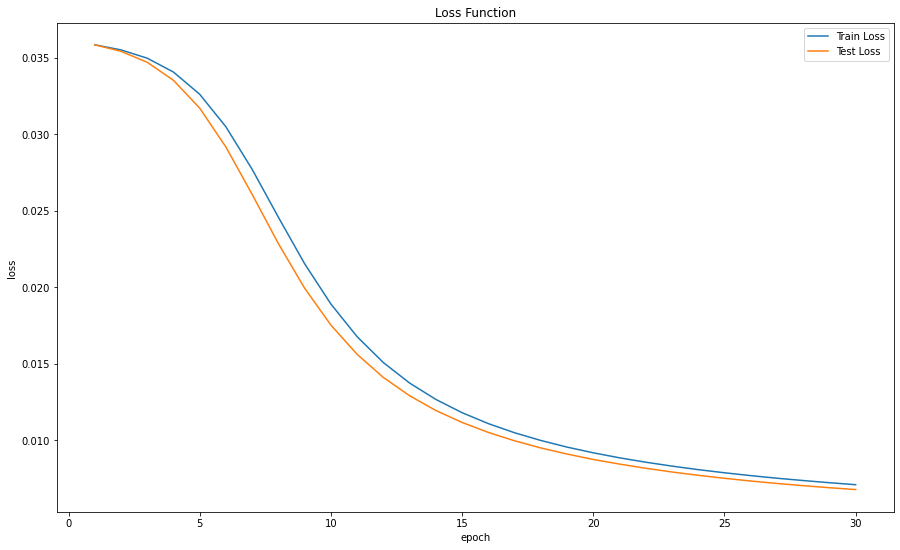

In [15]:
Draw_Loss_Curve()